# Data Cleaning and Preprocessing

In this notebook we will normailze our data by removing special characters, making all characters lowercase, removing extra spaces, and removing stopwords to help our model preform better.

In [3]:
# Imports
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter

In [4]:
# Loading in the data
df = pd.read_csv('data/final_reddit_posts.csv')

In [5]:
df.head(10)

,title,body,subreddit,post_id
0,ELI5: Why is it that when we watch footage fro...,"I don't know what it is, but it looks good and...",explainlikeimfive,ivd7cz
1,ELI5: Why are some spicy foods felt in the mou...,NaN,explainlikeimfive,a0xncr
2,How do our bones know to grow to be the same l...,"I was discussing this with a friend yesterday,...",askscience,1czga5y
3,ELI5: Types of fiber?,"What holds your crap together, what makes it l...",explainlikeimfive,1j8fu34
4,"ELI5- When you don’t eat for a period of time,...",NaN,explainlikeimfive,cnvbvv
5,"On Jupiter, will more superstorms the size the...",Hurricanes and big storms on Earth move around...,askscience,6exgpt
6,Is there a certain priority list for a severel...,Does human body have a priority list for heali...,askscience,8i6844
7,ELI5: If the blue pigment is so uncommon in na...,NaN,explainlikeimfive,8z1i1m
8,ELI5: Why prices are increasing but never decr...,NaN,explainlikeimfive,uadovh
9,ELI5: Why does your body feel physically ill a...,NaN,explainlikeimfive,6y9qw9


In [6]:
# Looking for null values
df.isnull().sum()

title           0
body         1273
subreddit       0
post_id         0
dtype: int64

In [7]:
df.groupby('subreddit')['body'].apply(lambda x: x.isnull().sum())

subreddit
askscience           559
explainlikeimfive    714
Name: body, dtype: int64

It looks like there a significant amount of null values coming from the body variable. Interestingly enough, there are 155 more body text missing from the subreddit explainlikeimfive. Those users might have less details to share. This makes sense since most users get their point accross in just the title of a subreddit. If I want my model to into account body, I cannot just drop null observations as my amount of data would be cut in about half. One solution I can think of is to replace the null values with ''. This way when we combine the text from both body and title, the title will be the only text left for those null observations.

In [9]:
# Filling missing body with ''
df = df.assign(body=df['body'].fillna(''))

# Verifying there are no more nulls
print(df.isnull().sum())

title        0
body         0
subreddit    0
post_id      0
dtype: int64


Great that solves our null values issues. Now the next cleaning step I wanted to take would be to normalize the body and title. I noticed that there are special characters as well as a mix of lover and upper case characters. We will use the Regex module to help detect the abscence and presence of text in our data.

https://www.geeksforgeeks.org/regular-expression-python-examples/

In [11]:
# Defining a function to convert to lowercase, remove extra spaces, and remove special characters of text
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text.strip()

# Applying text cleaning to title and body
df['title'] = df['title'].apply(clean_text)
df['body'] = df['body'].apply(clean_text)

In [12]:
# Checking if our function worked
df.head(20)

,title,body,subreddit,post_id
0,eli5 why is it that when we watch footage from...,i dont know what it is but it looks good and s...,explainlikeimfive,ivd7cz
1,eli5 why are some spicy foods felt in the mout...,,explainlikeimfive,a0xncr
2,how do our bones know to grow to be the same l...,i was discussing this with a friend yesterday ...,askscience,1czga5y
3,eli5 types of fiber,what holds your crap together what makes it lo...,explainlikeimfive,1j8fu34
4,eli5 when you dont eat for a period of time wh...,,explainlikeimfive,cnvbvv
5,on jupiter will more superstorms the size the ...,hurricanes and big storms on earth move around...,askscience,6exgpt
6,is there a certain priority list for a severel...,does human body have a priority list for heali...,askscience,8i6844
7,eli5 if the blue pigment is so uncommon in nat...,,explainlikeimfive,8z1i1m
8,eli5 why prices are increasing but never decre...,,explainlikeimfive,uadovh
9,eli5 why does your body feel physically ill af...,,explainlikeimfive,6y9qw9


Great looks like our function worked! Next item to clean will be the "eli5" at the begining of most of the explainlikeimfive subreddit. This could introduce bias into our classification.

* Overfitting Risk
    * If our model learns that "eli5" is a strong signal for this subreddit, it may rely too heavily on that keyword instead of focusing on the actual content of the post.
* Data Leakage Risk
    * If "eli5" appears in both the training and testing sets, the model could achieve artificially high accuracy without actually learning the difference in content complexity.

To fix this we will remove "elif" from both the title and body since some of our body text has the same text as the title.

In [14]:
# Removing 'eli5' from title and body
df['title'] = df['title'].str.replace(r'^\s*ELI5[:\-]?\s*', '', regex=True, flags=re.IGNORECASE)
df['body'] = df['body'].str.replace(r'^\s*ELI5[:\-]?\s*', '', regex=True, flags=re.IGNORECASE)

In [15]:
df.to_csv('data/reddit_post_cleaned_normalized_stopwords.csv', index=False)

Great that worked. Now we can move on to tokenizationa and removing stop words. This step is useful for NLP models

* Tokenization splits text into individual words (tokens), which helps the model analyze content meaningfully.
* Stopwords are common words (the, is, and, of...) that don’t carry significant meaning and can be removed to reduce noise.

In [17]:
# Assigning stopwords
stop_words = set(stopwords.words('english'))
# Creating a function to tokenize and remove stop words
def tokenize_and_remove_stopwords(text):
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)
# Applying to the text columns
df['title'] = df['title'].apply(tokenize_and_remove_stopwords)
df['body'] = df['body'].apply(tokenize_and_remove_stopwords)

In [18]:
df.head()

,title,body,subreddit,post_id
0,watch footage 70s lot times looks better foota...,dont know looks good sharp despite pixelated e...,explainlikeimfive,ivd7cz
1,spicy foods felt mouth ie hot sauce felt sinus...,,explainlikeimfive,a0xncr
2,bones know grow length,discussing friend yesterday trying work bones ...,askscience,1czga5y
3,types fiber,holds crap together makes loose helps go stay ...,explainlikeimfive,1j8fu34
4,dont eat period time sometimes feel nauseous p...,,explainlikeimfive,cnvbvv


We can now move on to lemmatization, which reduces words to their base or root form (running to run, better to good). This helps with normalization and improves text analysis. We are using leematization instead of stemming because it does a better job at understanding the meaning and context of the word instead of just chopping off word endings. This is critical because the matter in which a user asks a question seems like it will be a huge factor in predicting what subreddit it is coming from.

In [20]:
# Initializing lemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    if isinstance(text, str):
        tokens = text.split()
        lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]  
        return ' '.join(lemmatized_tokens)  
    return ''

# Applying lemmatization to both title and body
df['title'] = df['title'].apply(lemmatize_text)
df['body'] = df['body'].apply(lemmatize_text)

In [21]:
df.isnull().sum()

title        0
body         0
subreddit    0
post_id      0
dtype: int64

In [22]:
# Saving the dataset that is now cleaned, and normalized
#df.to_csv('data/reddit_post_cleaned_normalized.csv', index=False)

We are now ready to move on to vectorization to prepare the data for classification. We have several approches to choose from to address vectorization but I believe our model will best benefit from TF-IDF Vectorization to give significance to important words rather than common ones. We will limit the features (words) to 500 for now.

In [24]:
# Initializing TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=500)

# Combining title and body text as mentioned before
df['combined_text'] = df['title'] + ' ' + df['body']

# Appling TF-IDF transformation
X = tfidf_vectorizer.fit_transform(df['combined_text'])

# Checking shape of the transformed matrix
print(f"TF-IDF Matrix Shape: {X.shape}")

TF-IDF Matrix Shape: (2692, 500)


## Visualizing Normalized Text

Lets visualize the text length distrubtion after we have now normalized our text data.

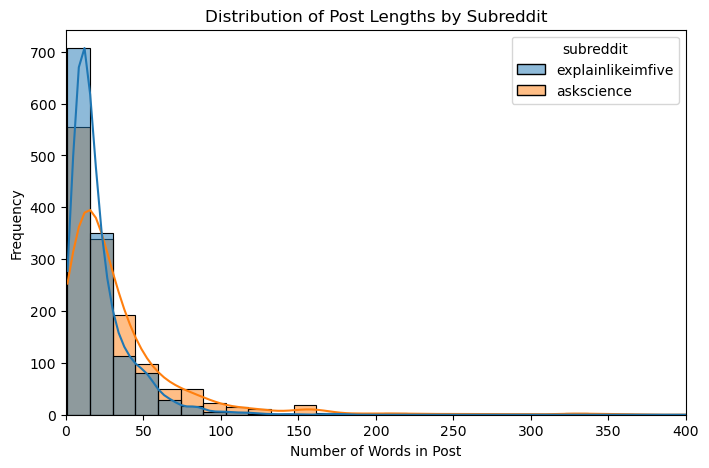

In [27]:
# text length
df['text_length'] = df['combined_text'].apply(lambda x: len(x.split()))

# Plotting the distribution
plt.figure(figsize=(8,5))
sns.histplot(df, x='text_length', hue='subreddit', bins=50, kde=True)
plt.title("Distribution of Post Lengths by Subreddit")
plt.xlabel("Number of Words in Post")
plt.ylabel("Frequency")
plt.xlim(0, 400)
plt.savefig('images/dist_post_by_subreddit.png', dpi=300)
plt.show()

It looks similar to our preliminary distribution. Now the explainlikeimfive subreddit has a higher frequency up until about 30 words.

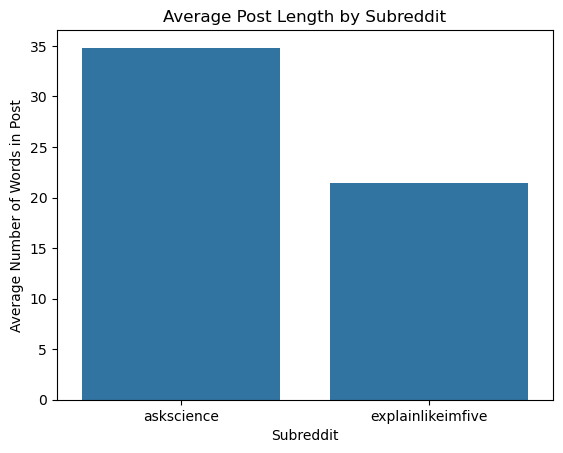

In [29]:
# Computing the average text length per subreddit
avg_text_length = df.groupby('subreddit')['text_length'].mean().reset_index()

# Plotting the bar chart
sns.barplot(data=avg_text_length, x='subreddit', y='text_length')
plt.title("Average Post Length by Subreddit")
plt.xlabel("Subreddit")
plt.ylabel("Average Number of Words in Post")
plt.savefig('images/avg_post_by_subreddit.png', dpi=300)
plt.show()

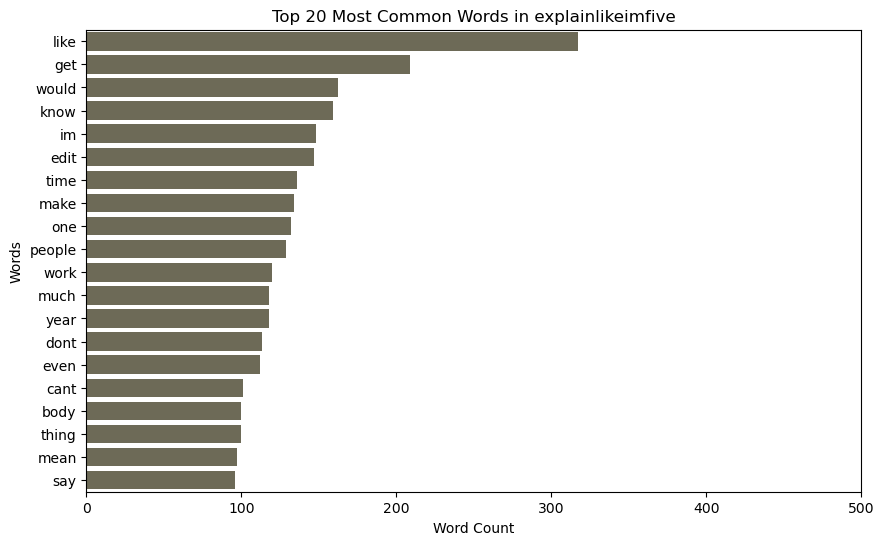

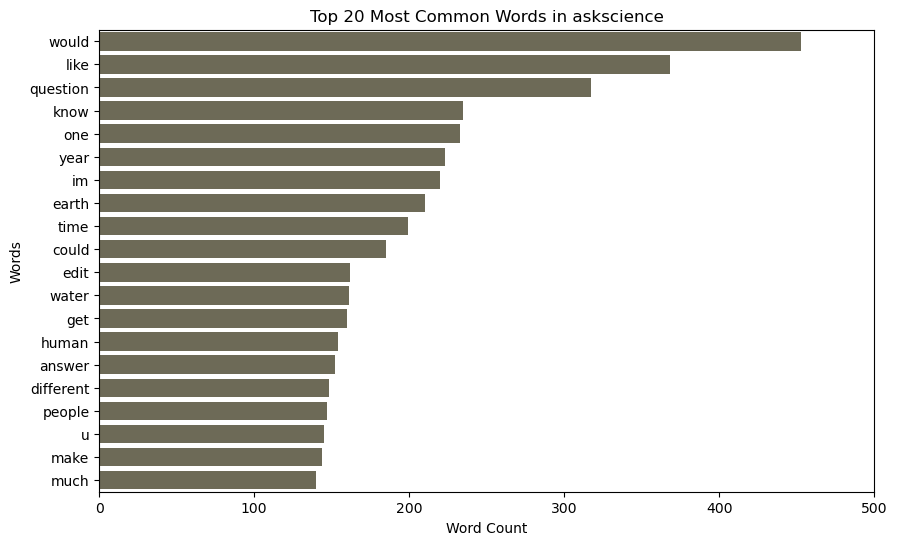

In [30]:
# Function to get the most common words
def plot_most_common_words(subreddit, n=20):
    text = " ".join(df[df['subreddit'] == subreddit]['combined_text'])
    words = text.split()
    word_counts = Counter(words)
    common_words = word_counts.most_common(n)
    words, counts = zip(*common_words)
    
    # Plotting
    plt.figure(figsize=(10,6))
    sns.barplot(x=list(counts), y=list(words), color= '#706D54')
    plt.title(f"Top {n} Most Common Words in {subreddit}")
    plt.xlabel("Word Count")
    plt.ylabel("Words")
    plt.xlim(0, 500)
    plt.savefig(f"images/most_common_words_{subreddit}.png", dpi=300)
    plt.show()

# Plotting for both subreddits
for subreddit in df['subreddit'].unique():
    plot_most_common_words(subreddit, n=20)

Interestingly enough, the ELIF subreddit has common words such as work and mean which are typically words one might ask when they are looking for a bigger picture style answer. The askscience subreddit has more measurable common words like time and year. The most common word in that subreddit is would.

In the next notebook we will transform the data using TF-IDF. This will leave give more significance to the important words and so it will be interesting to see how or if our barchart above changes at all.